# Notebook for plotting ComCam gains.

Adapted to AuxTel on 11 Apr 2022\
Initially written 18 Feb 2022 by Craig Lage.

In [2]:
date = '05May22'
print(f'Running this code on {date}')

Running this code on 05May22


In [3]:
import sys, os, glob, time
import numpy as np
import astropy.io.fits as pf
import matplotlib.pyplot as plt
import lsst.daf.butler as dafButler

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style('whitegrid')

## Exposure Log

For more information: https://docs.google.com/document/d/1v8nHTEv-a_OH1hhgmgBQq5E7DBG08f6mCDD3UqtTNtk/edit?usp=sharing

In [5]:
import lsst.daf.butler as dafButler
butler = dafButler.Butler("/repo/main", collections=["LATISS/raw/all","LATISS/calib"])

auxtel = {'20220502':[26,27],'20220407':[48,87],
          '20220406':[206,245],'20220405':[131,170],
          '20220317':[118,158],'20220316':[179,212]}


In [6]:
comcam = dict()

### Temperature Dependence


In [7]:
from lsst_efd_client import EfdClient, resample
from astropy.time import Time, TimeDelta

efd_client = EfdClient('summit_efd')

In [8]:
days = list(auxtel.keys())
nsize = len(days)
exposures = []
for day in days:
    exposures.append([int(int(day)*1e5+run) for run in auxtel[day]])
exposures

[[2022050200026, 2022050200027],
 [2022040700048, 2022040700087],
 [2022040600206, 2022040600245],
 [2022040500131, 2022040500170],
 [2022031700118, 2022031700158],
 [2022031600179, 2022031600212]]

In [9]:
times = []
for i in range(nsize):
    span = []
    for j in range(2):
        metadata = butler.get('raw.metadata', exposure=exposures[i][j], detector=0)
        tres = Time(metadata.toDict()['DATE'], format='isot', scale='tai')
        span.append(tres)
    times.append(span)
    
times

[[<Time object: scale='tai' format='isot' value=2022-05-03T00:25:05.057>,
  <Time object: scale='tai' format='isot' value=2022-05-03T00:25:10.619>],
 [<Time object: scale='tai' format='isot' value=2022-04-07T21:08:52.579>,
  <Time object: scale='tai' format='isot' value=2022-04-07T21:12:38.198>],
 [<Time object: scale='tai' format='isot' value=2022-04-06T22:36:14.188>,
  <Time object: scale='tai' format='isot' value=2022-04-06T22:39:59.843>],
 [<Time object: scale='tai' format='isot' value=2022-04-05T20:50:53.533>,
  <Time object: scale='tai' format='isot' value=2022-04-05T20:55:39.960>],
 [<Time object: scale='tai' format='isot' value=2022-03-17T20:04:16.602>,
  <Time object: scale='tai' format='isot' value=2022-03-17T23:14:03.886>],
 [<Time object: scale='tai' format='isot' value=2022-03-16T23:11:21.397>,
  <Time object: scale='tai' format='isot' value=2022-03-16T23:21:32.601>]]

In [10]:
temp_data = np.zeros(len(times), dtype=[('day', int),
                                        ('exp1',int),
                                        ('exp2',int),
                                        ('t1', float), 
                                        ('t1_err', float),
                                        ('t2', float), 
                                        ('t2_err', float)])

In [11]:
for i in range(len(times)):
    if exposures[i][0] < 20211013:
        # EFD was switched to UTC on 20211013.  This compensates for that.
        tai_offset = 37.0
    else:
        tai_offset = 0.0
    t1 = times[i][0] - TimeDelta(-10., format='sec', scale='tai')
    t2 = times[i][1] + TimeDelta(+10., format='sec', scale='tai')

    res1 = await efd_client.select_time_series("lsst.sal.ATCamera.focal_plane_Reb", 
                                               ["aspicl_Temp00","aspicu_Temp00"], 
                                               t1.utc - TimeDelta(tai_offset, format='sec'), 
                                               t2.utc - TimeDelta(tai_offset, format='sec'))
    print(res1)
    if len(res1)>0:
        t1 = np.mean(res1['aspicl_Temp00'])
        t1_err = np.std(res1['aspicl_Temp00'])
        t2 = np.mean(res1['aspicu_Temp00'])
        t2_err = np.std(res1['aspicu_Temp00'])

    else:
        t1 = np.nan
        t1_err = np.nan
        t2 = np.nan
        t2_err = np.nan
        
    temp_data[i] = (int(days[i]), exposures[i][0], exposures[i][1], t1, t1_err, t2, t2_err)


                                  aspicl_Temp00  aspicu_Temp00
2022-05-03 00:24:42.037000+00:00       9.910714       9.933036
                                  aspicl_Temp00  aspicu_Temp00
2022-04-07 21:08:32.570000+00:00      16.562500      16.584822
2022-04-07 21:08:43.235000+00:00      16.584822      16.584822
2022-04-07 21:08:49.310000+00:00      16.562500      16.562500
2022-04-07 21:09:02.309000+00:00      16.674107      16.674107
2022-04-07 21:09:12.500000+00:00      16.696428      16.584822
2022-04-07 21:09:22.571000+00:00      16.562500      16.584822
2022-04-07 21:09:33.235000+00:00      16.629465      16.517857
2022-04-07 21:09:43.235000+00:00      16.562500      16.584822
2022-04-07 21:09:52.570000+00:00      16.540178      16.562500
2022-04-07 21:10:03.234000+00:00      16.562500      16.562500
2022-04-07 21:10:03.235000+00:00      16.562500      16.562500
2022-04-07 21:10:05.238000+00:00      16.562500      16.562500
2022-04-07 21:10:15.237000+00:00      16.517857      16

In [12]:
temp_data

array([(20220502, 2022050200026, 2022050200027,  9.91071415, 0.        ,  9.93303585, 0.        ),
       (20220407, 2022040700048, 2022040700087, 16.55691946, 0.04767885, 16.56877792, 0.07302234),
       (20220406, 2022040600206, 2022040600245, 12.11045514, 0.11379463, 12.10973494, 0.07771168),
       (20220405, 2022040500131, 2022040500170, 16.45577574, 0.08309555, 16.46275139, 0.05607752),
       (20220317, 2022031700118, 2022031700158, 12.76326293, 1.67325789, 12.77351872, 1.67357991),
       (20220316, 2022031600179, 2022031600212, 12.66909247, 0.14313772, 12.67734828, 0.14145757)],
      dtype=[('day', '<i8'), ('exp1', '<i8'), ('exp2', '<i8'), ('t1', '<f8'), ('t1_err', '<f8'), ('t2', '<f8'), ('t2_err', '<f8')])

In [34]:
temp_data['day'] = temp_data['day'].astype(str)

<ErrorbarContainer object of 3 artists>

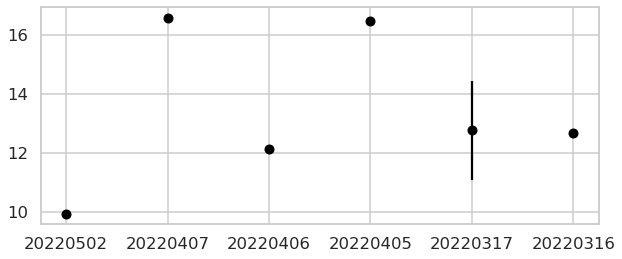

In [35]:
plt.figure(figsize=(10,4))
plt.errorbar((temp_data['day']).astype(str),temp_data['t1'],temp_data['t1_err'],fmt='ko')
# plt.errorbar(days,temp_data['t2'],temp_data['t2_err'],fmt='ro')

In [36]:
np.save(f'data/temp_auxtel_{day}.npy', temp_data)

In [37]:
tmp = np.load(f'data/temp_auxtel_{day}.npy')

In [38]:
tmp

array([(20220502, 2022050200026, 2022050200027,  9.91071415, 0.        ,  9.93303585, 0.        ),
       (20220407, 2022040700048, 2022040700087, 16.55691946, 0.04767885, 16.56877792, 0.07302234),
       (20220406, 2022040600206, 2022040600245, 12.11045514, 0.11379463, 12.10973494, 0.07771168),
       (20220405, 2022040500131, 2022040500170, 16.45577574, 0.08309555, 16.46275139, 0.05607752),
       (20220317, 2022031700118, 2022031700158, 12.76326293, 1.67325789, 12.77351872, 1.67357991),
       (20220316, 2022031600179, 2022031600212, 12.66909247, 0.14313772, 12.67734828, 0.14145757)],
      dtype=[('day', '<i8'), ('exp1', '<i8'), ('exp2', '<i8'), ('t1', '<f8'), ('t1_err', '<f8'), ('t2', '<f8'), ('t2_err', '<f8')])

In [41]:
import lsst.daf.butler as dafButler

butler1 = dafButler.Butler("/repo/main", collections=["LATISS/raw/all","LATISS/calib", f"u/jesteves/latiss/ptc_tREB"])


In [49]:
for i in range(4):
    flat1ID = tmp['exp1'][i]
    cpCovs = butler1.get('cpCovariances', detector=0, exposure=flat1ID, instrument='LATISS')
    gain_values = cpCovs.gain
    noise_values = cpCovs.noise
    print(flat1ID)

2022050200026


LookupError: Dataset cpCovariances with data ID {instrument: 'LATISS', detector: 0, exposure: 2022040700048} could not be found in collections [LATISS/raw/all, LATISS/calib, u/jesteves/latiss/ptc_tREB].

NameError: name 'np' is not defined

### Re-run the 20220504 exposure

Synthax:
```
pipetask run -j 32 -d "detector IN (0) AND instrument='LATISS' AND \
	 exposure IN (${obsDate}${flat_ptc0}..${obsDate}${flat_ptc1}) AND exposure.observation_type='flat'" \
	 -b /repo/main \
     -c isr:doFlat=False \
     -i LATISS/raw/all,LATISS/calib,LATISS/calib,u/jesteves/calib/latiss/calib.${obsDate} \
	 -o u/jesteves/latiss/ptc_${obsDate}_flat_rerun \
	 -p $CP_PIPE_DIR/pipelines/Latiss/cpPtc.yaml \
	 --register-dataset-types

```

In [ ]:
temp_data

In [ ]:
data

In [ ]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row',figsize=(10,5))
for i in range(len(exposures)):
    ax[0].scatter(temp_data['t2'][i],data['gain'][i],s=100,label=run_names[i])
ax[0].legend(fontsize=12)
ax[0].errorbar(temp_data['t2'],data['gain'],xerr=temp_data['t2_err'],yerr=data['gain_err'],
             fmt='.w',capsize=3,ecolor='k')

ax[0].set_xlabel('Temp [°C]: aspicu_Temp00')
ax[0].set_ylabel('Mean Gain')
ax[0].set_title('Auxtel: May 13 2022')

for i in range(len(exposures)):
    ax[1].scatter(temp_data['t1'][i],data['gain'][i],s=100,label=run_names[i])
ax[1].legend(fontsize=12)
ax[1].errorbar(temp_data['t1'],data['gain'],xerr=temp_data['t1_err'],yerr=data['gain_err'],
             fmt='.w',capsize=3,ecolor='k')

ax[1].set_xlabel('Temp [°C]: aspicl_Temp00')
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.tight_layout()
fig.savefig(f'./plots/temp_gain_relation_May13.pdf',dpi=100)

In [ ]:
for i in range(len(exposures)):
    plt.scatter(temp_data['t2'][i],data['gain'][i],s=100,label=run_names[i])
plt.legend(fontsize=12)
plt.errorbar(temp_data['t2'],data['gain'],xerr=temp_data['t2_err'],yerr=data['gain_err'],
             fmt='.w',capsize=3,ecolor='k')

plt.xlabel('Temp [°C]: aspicu_Temp00')
plt.ylabel('Mean Gain')
plt.title('Auxtel: May 13 2022')
# plt.xlim(15.8,16.5)

In [ ]:
dashboardTime = metadata.toDict()['DATE']
upperDashboardTime = metadata.toDict()['DATE'][:-6]+str(float(metadata.toDict()['DATE'][-6:])+5.)
query = f"""SELECT "aspicl_Temp00", "aspicu_Temp00" FROM "efd"."autogen"."lsst.sal.ATCamera.focal_plane_Reb" WHERE time > :{dashboardTime}: AND time < :{upperDashboardTime}:"""
print(query)


In [ ]:
# res = await efd_client.influx_client.query(query)